In [1]:
install.packages("tidyquant")
library(tidyverse)
library(tidyquant)
library(timetk)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘timetk’


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.2     ✔ tibble    3.3.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.2
✔ purrr     1.2.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

── Attaching core tidyquant packages ─────────────────────── tidyquant 1.0.11 ──
✔ PerformanceAnalytics 2.0.8      ✔ TTR                  0.24.4
✔ quantmod             0.4.28     ✔ xts                  0.14.1
── Conflicts ──────────────────────────────

Warning message:
“There was 1 warning in `dplyr::mutate()`.
ℹ In argument: `nested.col = purrr::map(...)`.
ℹ In group 2: `symbol = "GC=F"`.
Caused by warning in `to_period()`:
! missing values removed from data”


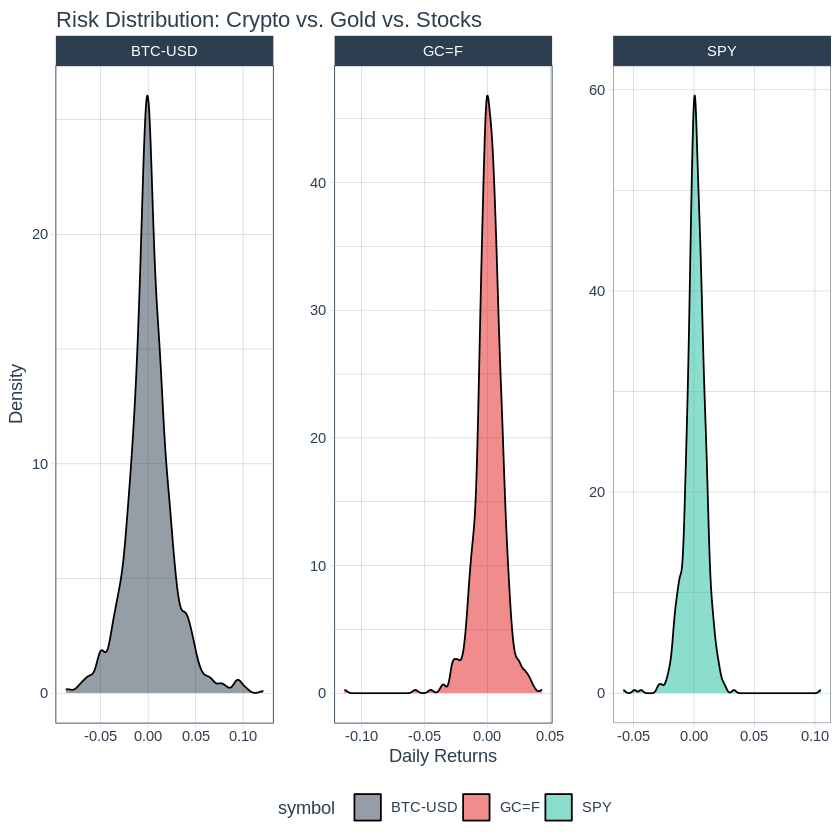

In [2]:
symbols <- c("BTC-USD", "GC=F", "SPY")
data <- tq_get(symbols, from = "2023-01-01", to = "2026-02-01") %>%
  group_by(symbol) %>%
  tq_transmute(select = adjusted, mutate_fun = periodReturn, period = "daily", col_rename = "returns")

ggplot(data, aes(x = returns, fill = symbol)) +
  geom_density(alpha = 0.5) +
  labs(title = "Risk Distribution: Crypto vs. Gold vs. Stocks",
       x = "Daily Returns", y = "Density") +
  theme_tq() +
  scale_fill_tq() +
  facet_wrap(~symbol, scales = "free")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


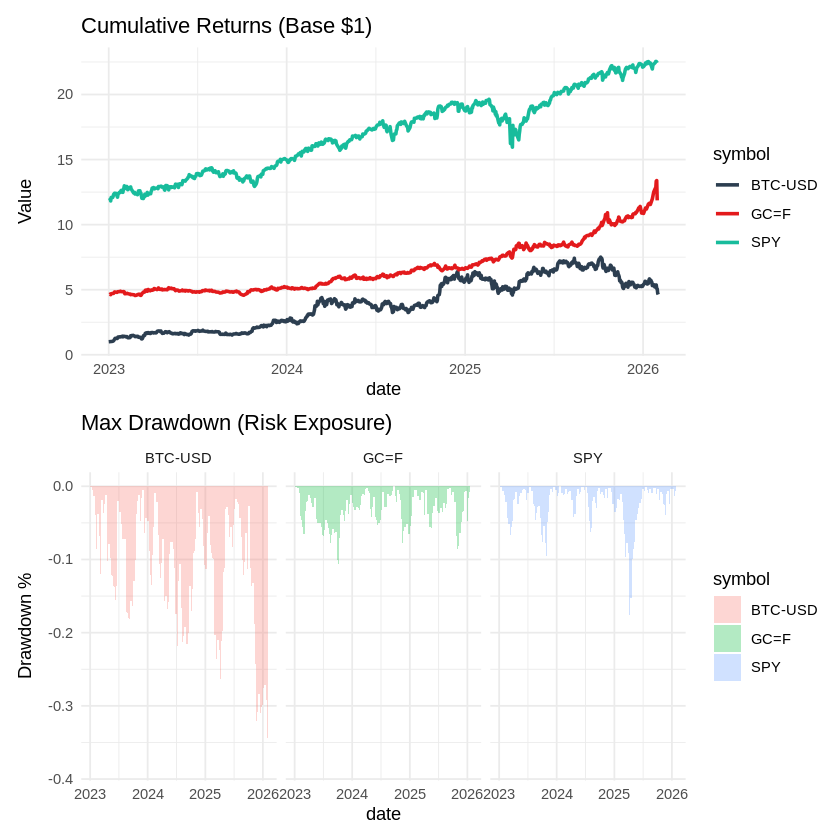

In [3]:
install.packages("patchwork")
library(patchwork)

# 1. Price Trend Plot
p1 <- data %>%
  tq_mutate(select = returns, mutate_fun = runMean, n = 30, col_rename = "ma30") %>%
  ggplot(aes(x = date, y = cumprod(1 + returns), color = symbol)) +
  geom_line(size = 1) +
  theme_minimal() +
  labs(title = "Cumulative Returns (Base $1)", y = "Value") +
  scale_color_tq()

# 2. Drawdown Plot (How much money you could have lost at the worst time)
p2 <- data %>%
  group_by(symbol) %>%
  mutate(cum_ret = cumprod(1 + returns),
         max_ret = cummax(cum_ret),
         drawdown = (cum_ret - max_ret) / max_ret) %>%
  ggplot(aes(x = date, y = drawdown, fill = symbol)) +
  geom_area(alpha = 0.3) +
  theme_minimal() +
  labs(title = "Max Drawdown (Risk Exposure)", y = "Drawdown %") +
  facet_wrap(~symbol)

p1 / p2

In [4]:
# Sharpe Ratio (Reward-to-Risk)
ra_metrics <- data %>%
  group_by(symbol) %>%
  tq_performance(Ra = returns, performance_fun = SharpeRatio)

print(ra_metrics)

# A tibble: 3 × 5
# Groups:   symbol [3]
  symbol  `ESSharpe(Rf=0%,p=95%)` SemiSDSharpe(Rf=0%,p=…¹ StdDevSharpe(Rf=0%,p…²
  <chr>                     <dbl>                   <dbl>                  <dbl>
1 BTC-USD                  0.0399                  0.0718                 0.0678
2 GC=F                     0.0229                  0.104                  0.112 
3 SPY                      0.105                   0.0907                 0.0908
# ℹ abbreviated names: ¹​`SemiSDSharpe(Rf=0%,p=95%)`,
#   ²​`StdDevSharpe(Rf=0%,p=95%)`
# ℹ 1 more variable: `VaRSharpe(Rf=0%,p=95%)` <dbl>


In [5]:
install.packages("rugarch")
library(rugarch)
library(tidyquant)
library(tidyverse)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘truncnorm’, ‘FNN’, ‘kernlab’, ‘mclust’, ‘multicool’, ‘pracma’, ‘DistributionUtils’, ‘GeneralizedHyperbolic’, ‘Rsolnp’, ‘ks’, ‘spd’, ‘chron’, ‘SkewHyperbolic’, ‘nloptr’


Loading required package: parallel


Attaching package: ‘rugarch’


The following object is masked from ‘package:purrr’:

    reduce




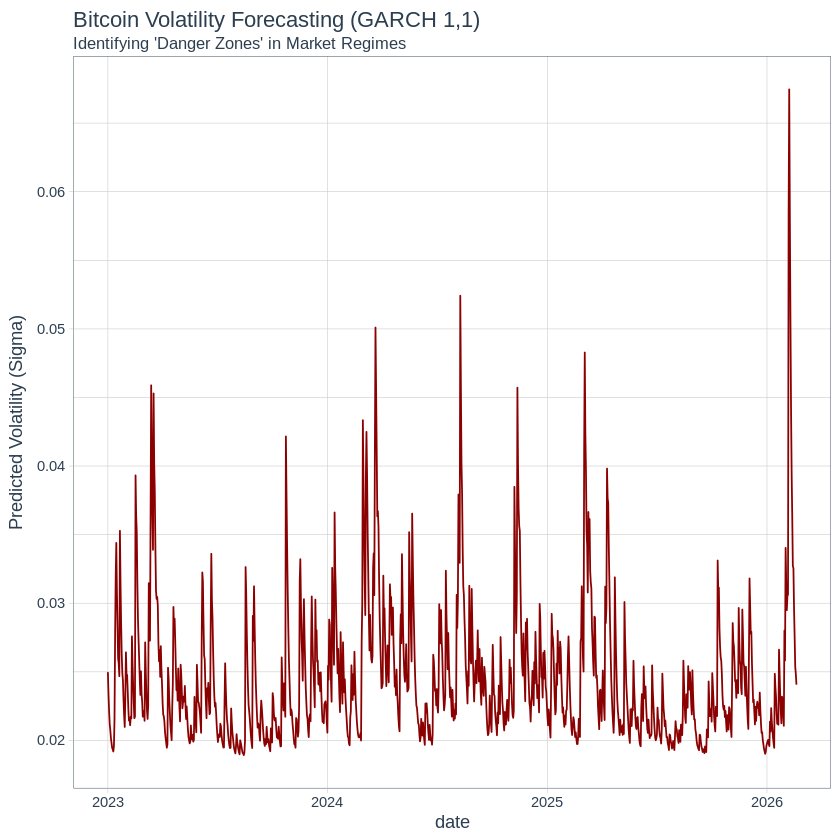

In [6]:
btc_data <- tq_get("BTC-USD", from = "2023-01-01") %>%
  tq_transmute(select = adjusted, mutate_fun = periodReturn, period = "daily", col_rename = "ret")

spec <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 1)),
                   mean.model = list(armaOrder = c(0, 0)))

fit <- ugarchfit(spec = spec, data = btc_data$ret)

btc_data$predicted_vol <- as.numeric(sigma(fit))

ggplot(btc_data, aes(x = date, y = predicted_vol)) +
  geom_line(color = "darkred") +
  theme_tq() +
  labs(title = "Bitcoin Volatility Forecasting (GARCH 1,1)",
       subtitle = "Identifying 'Danger Zones' in Market Regimes",
       y = "Predicted Volatility (Sigma)")

In [7]:
# portfolio
symbols <- c("AAPL", "GC=F", "BTC-USD")
weights <- c(0.4, 0.3, 0.3) # 40% Apple, 30% Gold, 30% Bitcoin

portfolio_returns <- tq_get(symbols, from = "2023-01-01") %>%
  group_by(symbol) %>%
  tq_transmute(select = adjusted, mutate_fun = periodReturn, period = "daily", col_rename = "ret") %>%
  tq_portfolio(assets_col = symbol, returns_col = ret, weights = weights, col_rename = "port_ret")

head(portfolio_returns)

Warning message:
“There was 1 warning in `dplyr::mutate()`.
ℹ In argument: `nested.col = purrr::map(...)`.
ℹ In group 3: `symbol = "GC=F"`.
Caused by warning in `to_period()`:
! missing values removed from data”
Warning message in PerformanceAnalytics::Return.portfolio(., weights = weights, :
“NA's detected: filling NA's with zeros”


date,port_ret
<date>,<dbl>
2023-01-01,0.0000000000
2023-01-02,0.0011438855
2023-01-03,-0.0001552493
2023-01-04,0.0095616032
2023-01-05,-0.0076186550
2023-01-06,0.0215238069


In [8]:

spec <- ugarchspec(
  variance.model = list(model = "sGARCH", garchOrder = c(1, 1)),
  mean.model = list(armaOrder = c(0, 0)),
  distribution.model = "std"
)

fit <- ugarchfit(spec = spec, data = portfolio_returns$port_ret)


forecast <- ugarchforecast(fit, n.ahead = 5)


portfolio_returns$VaR_95 <- as.numeric(quantile(fit, probs = 0.05))

print(forecast)


*------------------------------------*
*       GARCH Model Forecast         *
*------------------------------------*
Model: sGARCH
Horizon: 5
Roll Steps: 0
Out of Sample: 0

0-roll forecast [T0=1973-02-20]:
       Series   Sigma
T+1 0.0008001 0.01896
T+2 0.0008001 0.01900
T+3 0.0008001 0.01903
T+4 0.0008001 0.01907
T+5 0.0008001 0.01910




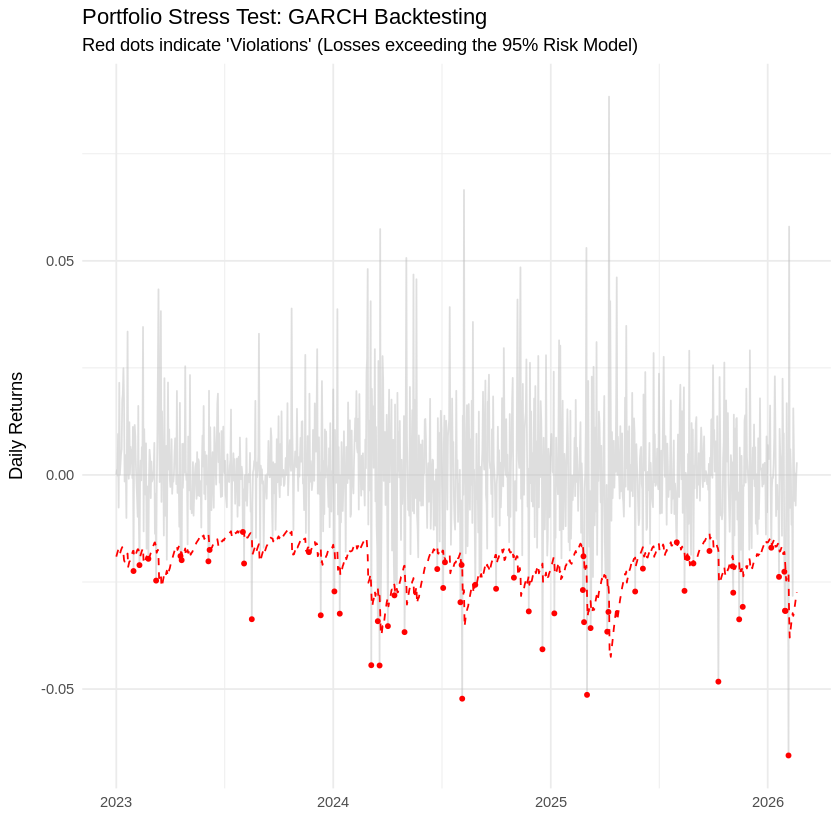

In [9]:
ggplot(portfolio_returns, aes(x = date)) +
  geom_line(aes(y = port_ret), color = "gray", alpha = 0.5) +
  geom_line(aes(y = VaR_95), color = "red", linetype = "dashed") +
  geom_point(data = filter(portfolio_returns, port_ret < VaR_95),
             aes(y = port_ret), color = "red", size = 1) +
  theme_minimal() +
  labs(title = "Portfolio Stress Test: GARCH Backtesting",
       subtitle = "Red dots indicate 'Violations' (Losses exceeding the 95% Risk Model)",
       y = "Daily Returns", x = "")